In [1]:
import os
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Point
import shapely
import missingno as msn
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from sklearn.cluster import DBSCAN
from skmultiflow.drift_detection.adwin import ADWIN
from skmultiflow.drift_detection import DDM
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('AISData.csv')
gdf = gpd.GeoDataFrame(df.drop(['location.coordinates.0', 'location.coordinates.1'], axis=1),
crs={'init': 'epsg:4326'},
geometry=[shapely.geometry.Point(xy) for xy in zip(df['location.coordinates.0'], df['location.coordinates.1'])])

In [3]:
# Print the AIS data
gdf.head()

,Unnamed: 0,event_time,position_accuracy,mmsi,sog,cog,geometry
0,0,2019-04-11T09:47:30.153Z,0.0,316013808,3.0,319.500000,POINT (-63.55608166666666 44.624835)
1,1,2019-04-11T09:47:27.273Z,0.0,316013808,3.0,320.700012,POINT (-63.55605333333333 44.62481666666667)
2,2,2019-04-11T09:47:34.340Z,0.0,316013808,2.9,319.500000,POINT (-63.55613833333334 44.62486833333333)
3,3,2019-04-11T09:47:37.087Z,0.0,316013808,3.0,319.799988,POINT (-63.55618666666667 44.62489833333333)
4,4,2019-04-19T09:52:19.358Z,0.0,316013808,3.2,337.200012,POINT (-63.55599833333334 44.62488333333334)


In [ ]:
# Read the shape file and set port names as index
nima_ports=gpd.read_file('assignment3shapefile.shp')
print(nima_ports.head())
ports = nima_ports
nima_ports=nima_ports.set_index(['port_name'])
ports_without_buffer = nima_ports

   field_1     port_name    size  \
0        0  pointpolygon  0.0000   
1        1         port1  0.0018   
2        2         port2  0.0018   
3        3           ind  0.0000   
4        4         port5  0.0018   

                                            geometry  
0  POLYGON ((-63.59160304069519 44.6649292254607,...  
1  POLYGON ((-63.569431 44.649993, -63.5694396674...  
2  POLYGON ((-63.60949000000001 44.675853, -63.60...  
3  POLYGON ((-63.54742169380188 44.64697911403847...  
4  POLYGON ((-63.568048 44.663875, -63.5680566674...  


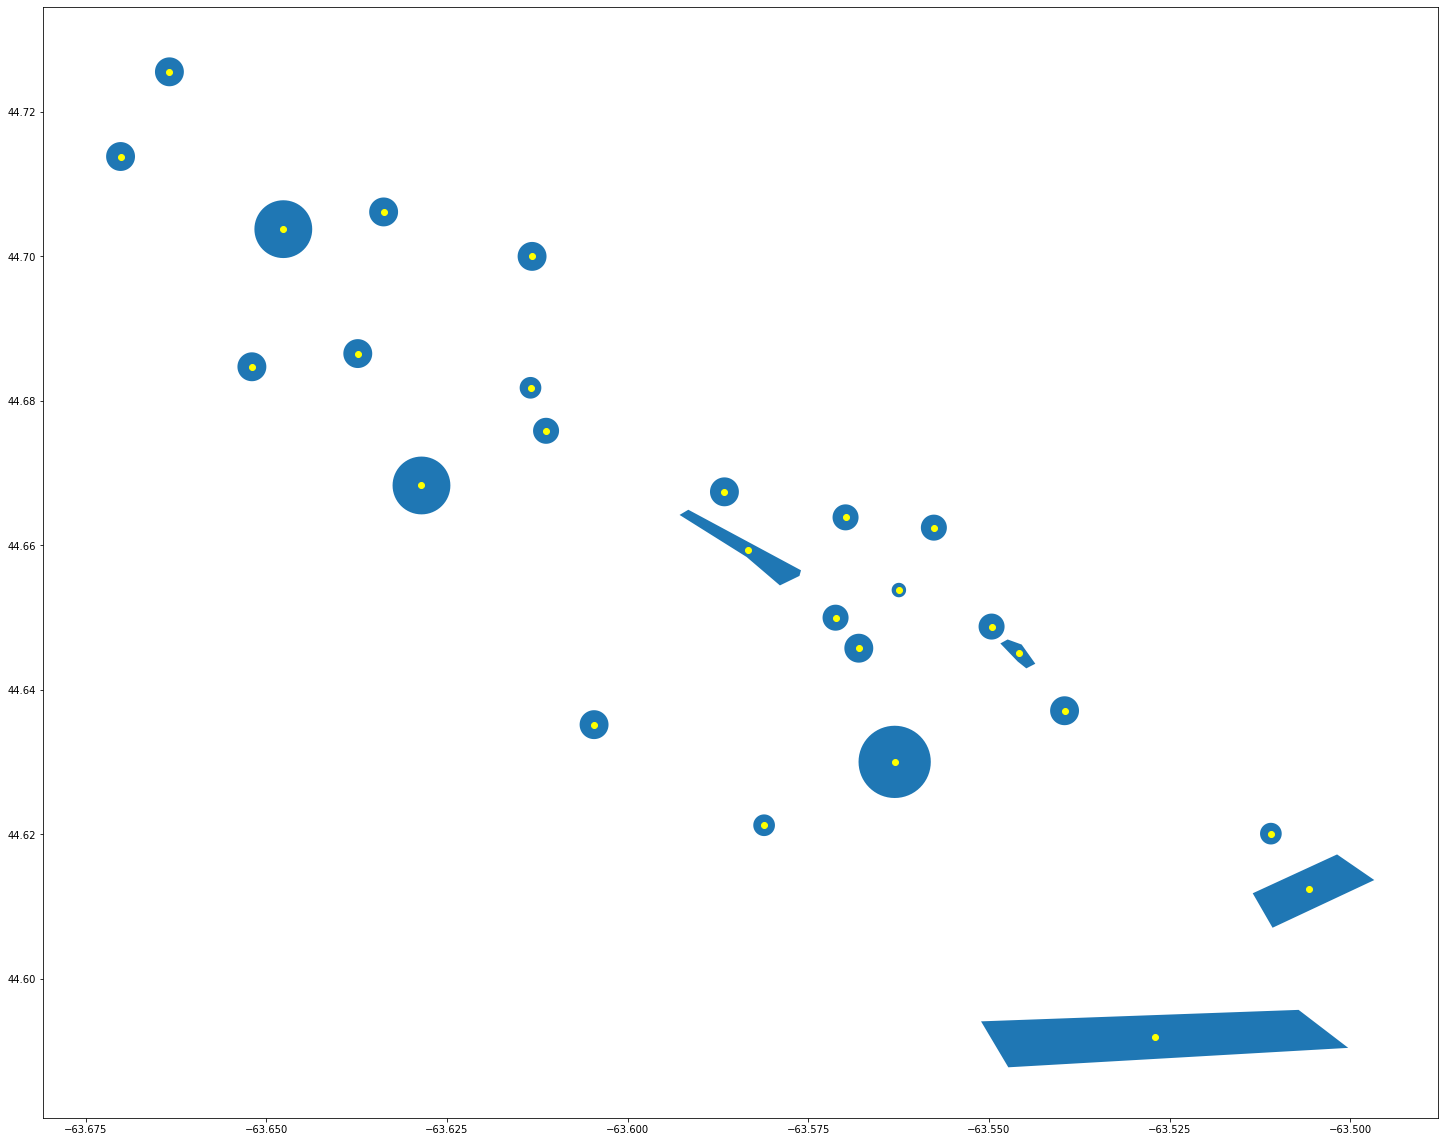

In [ ]:
# Plot port data without buffers
centers = nima_ports.centroid
ax = nima_ports.plot(figsize=(25,25))
gpd.GeoSeries(centers).plot(ax=ax,color='yellow')

In [ ]:
# AIS messages plot
gdf.plot(figsize=(25,25))

# Question 1

In the first part a buffer is created around the ports and later the messages that intersect the port buffers are plotted in red. 

The AIS messages and port data are combined using the Geopandas spatial join as shown below.

In [ ]:
# Create a buffer and show the intersection of ship messages with ports 
nima_ports['geometry'] = nima_ports['geometry'].buffer(0.001)
ax2 = nima_ports.buffer(0.001).plot(figsize=(25,25), color='g', alpha=0.6)

joinres=gpd.sjoin(gdf,nima_ports,op='intersects',how='inner')
joinres.plot(ax=ax2, color='r', markersize=5)

# Question 2

Each port has a message density based on the mesasges sent by different vessels. In order to highlight the number of messages in a given port, I have used a color coding scheme.

The color coding scheme for messages to a port is given by:
* Orange if the number of messages lies between 1-230
* Blue if the number of messages lies between 230-1500
* Green if the number of messages is greater than 1500
* Black if there were no messages received


In [ ]:
port_count = joinres['index_right'].value_counts()
ax = ports_without_buffer.plot(figsize= (25,25), color='black', alpha=0.5)

def get_color(i):
    if(i < 230 and i>0):
        color='orange'
    elif(i >= 230 and i <=1500):
        color='blue'
    elif(i > 1500):
        color='green'
    return color

for i in range(len(port_count)):
    color = get_color(port_count[i])
    ports_without_buffer[ports_without_buffer.index == port_count.index[i]]['geometry'].plot(ax=ax, color=color)


# Question 3

The entire dataset is divided into one hour intervals and the vessel message plots are made. The plots are stored in a folder called <b>"images"</b> in the current directory and each image has the following naming convention:


<b>Figure number/hour</b> 

The figure number is just a reference to show the number of figures and the hour specifies the message density at a particular hour.

In [ ]:
date_obj = pd.to_datetime(joinres['event_time'], utc=True)
list_split_by_hour = [g.reset_index(drop=True) for i,g in joinres.groupby([date_obj.dt.date,date_obj.dt.hour])]

In [ ]:
len(list_split_by_hour)

In [ ]:
list_split_by_hour[1]

In [ ]:
filename = "./images"
os.makedirs(filename, exist_ok=True)

for i in range(len(list_split_by_hour)):
    ax2 = nima_ports.buffer(0.001).plot(figsize=(25,25), color='g', alpha=0.6)
    fig = list_split_by_hour[i].plot(figsize=(25,25), ax=ax2).get_figure()
    plt.savefig("{0}/Figure {1}:{2}.png".format(filename,i,list_split_by_hour[i]['event_time'].str.split('T').iloc[0][1].split(':')[0]))
        

# Question 4

I have selected the port "auto_port" and I have first filtered all the AIS messages using the dataframe obtained from the sjoin operation in step 2. Also, from step 3, I have split the messages into one hour intervals for auto_port and I have calculated the number of messages by just taking the length of each of the dataframe for one hour intervals.


In the plot below, the y-axis shows the density of messages on an hourly basis on different days, whereas the x-axis shows the timestamps in the follwoing format: <b>date/hour:</b>. The date part represents the day on which the messages were intercepted and the hour provides the hour at which the message was intercepted on that particular day.

In [ ]:
port7 = joinres[joinres['index_right'] == 'port7']

In [ ]:
date_obj = pd.to_datetime(port7['event_time'], utc=True)
port_list_split_by_hour = [g for i,g in port7.groupby([date_obj.dt.date,date_obj.dt.hour])]
density_plot = pd.DataFrame(columns = ['time', 'density'])
for i in range(len(port_list_split_by_hour)):
    density_plot.at[i,'density'] = len(port_list_split_by_hour[i])
    density_plot.at[i,'time'] = port_list_split_by_hour[i]['event_time'].str.split('T').iloc[0][0] + "/hour:" + port_list_split_by_hour[i]['event_time'].str.split('T').iloc[0][1].split(':')[0]

density_plot.plot(x='time', y='density', figsize=(20,5)) 
plt.xticks(rotation=90)
plt.show()

# Question 5

I have used ADWIN for drift detection. By the changing the delta parameter, we can see that higher the value of delta, the number of changes detected is higher. Since the window size increases, the number of changes detected by ADWIN increases. As we can see from the graph below, there are drastic changes in message densities at around indices 900, 1500. These changes are caught when the window size (delta) has been set to 0.005. 

In [ ]:
density_plot_matrix = density_plot.as_matrix()
densities = []
for i in range(len(density_plot_matrix)):
    densities.append(density_plot_matrix[i][1])

plt.figure(figsize=(10,10))
plt.plot(densities)

# Drift detection using ADWIN with delta=0.00001
print("Adwin with delta = 0.00001")
adwin = ADWIN(delta=0.00001)
for i in range(len(density_plot_matrix)):
    adwin.add_element(density_plot_matrix[i][1])
    if adwin.detected_change():
        print('(ADWIN) Change detected in data: ' + str(density_plot_matrix[i][1]) + ' - at index: ' + str(i))

# Drift detection using ADWIN with delta=0.005
print("Adwin with delta = 0.005")
adwin = ADWIN(delta=0.005)
for i in range(len(density_plot_matrix)):
    adwin.add_element(density_plot_matrix[i][1])
    if adwin.detected_change():
        print('(ADWIN) Change detected in data: ' + str(density_plot_matrix[i][1]) + ' - at index: ' + str(i))

# Question 6

From the result of sjoin, all ports are clustered using DBSCAN based on their message densities. Based on the density value, a particular cluster is given a certain color as shown below in the graph.

In [ ]:
count = joinres['index_right'].value_counts()
set(count.keys())
set(ports_without_buffer.index)
zero_density_ports = set(ports_without_buffer.index) - set(count.keys())
zero_density_ports = pd.DataFrame(zero_density_ports, columns=['port_name'])
zero_density_ports['message_density'] = 0

In [ ]:
count = joinres['index_right'].value_counts()
message_density_df = pd.DataFrame(columns = ["port_name","message_density"])
for i in range(len(count)):
    message_density_df.at[i,'port_name'] = count.keys()[i]
    message_density_df.at[i,'message_density'] = count.values[i]

port_df = pd.concat([message_density_df,zero_density_ports], ignore_index=True)

port_df['port_index'] = port_df.index.values
port_df_with_index = port_df[['port_index','message_density']]
port_df

In [ ]:
clustering = DBSCAN(eps = 300, min_samples=2).fit_predict(port_df_with_index)
clustering

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(port_df['port_name'],port_df['message_density'], c=clustering)
plt.xticks(rotation=90)
plt.show()